# Join Adjacency Matrix, Gene Expression & Labels

In [1]:
import pandas
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import h5py
import mygene
%matplotlib inline

## Get Gene Expression

In [2]:
# params
TIMES_STD_THRESHOLD = 10.
MAX_ZEROS_ALLOWED = .5
SCALE = False

In [3]:
# load data
gene_expression = pandas.DataFrame.from_csv('gene_expression/normalized-counts-labels.csv',
                                            encoding='utf-8', sep=',')
ge_nonames = gene_expression.drop('Name', axis=1)

# kick out super highly expressed genes
threshold = ge_nonames.mean(axis=1).std()*TIMES_STD_THRESHOLD
#print ("Threshold Gene Expression: {}".format(threshold))
anomalies = gene_expression[ge_nonames.mean(axis=1) > threshold]
ge_anomalies_removed = ge_nonames.drop(anomalies.index)

# kick out genes with too many zeros
ge_zeros_removed = ge_anomalies_removed[ge_anomalies_removed.astype('bool').mean(axis=1)>=(1-MAX_ZEROS_ALLOWED)]

# write gene expression to file to perform differential expression analysis on it
ge_zeros_removed.to_csv('../data/preprocessing/gene_expression_counts.tsv', sep='\t')

# scaling
if SCALE:
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(ge_zeros_removed)
    ge_scaled = pandas.DataFrame(scaled_features,
                                 index=ge_zeros_removed.index,
                                 columns=ge_zeros_removed.columns)
else:
    ge_scaled = ge_zeros_removed

# print some information
print ("Had gene expression for {} genes in the beginning.".format(ge_nonames.shape[0]))
print ("kicked out {} super highly expressed genes".format(ge_nonames.shape[0] - ge_anomalies_removed.shape[0]))
print ("Kicked out {} genes with more than {}% zeros".format(ge_anomalies_removed.shape[0]-ge_zeros_removed.shape[0],
                                                             MAX_ZEROS_ALLOWED*100.
                                                            ))
print ("==> Left with gene expression for {} genes".format(ge_scaled.shape[0]))

Had gene expression for 41424 genes in the beginning.
kicked out 9 super highly expressed genes
Kicked out 15021 genes with more than 50.0% zeros
==> Left with gene expression for 26394 genes


In [4]:
gene_names = gene_expression.loc[ge_scaled.index].Name.values
gene_ids = ge_scaled.index
gene_expression.head()

,Name,Pam3T16,Pam3T8,Pam3T16.1,Pam3T8.1,Pam3T16.2,Pam3T8.2,ControlT8,ControlT16,ControlT8.1,...,gfpmT8.1,gfpmT16.1,gfpmT8.2,gfpmT16.2,gfppT8,gfppT16,gfppT8.1,gfppT16.1,gfppT8.2,gfppT16.2
Ensembl-ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,6.736327,8.519666,10.773706,10.813725,2.427830,7.425264,9.417385,7.920964,10.812953,...,12.529836,6.769370,13.440488,5.248289,14.583375,13.538040,18.220493,14.908853,16.156797,30.745221
ENSG00000000419,DPM1,97.676739,73.025712,132.362676,110.840686,87.401897,87.865624,92.725018,105.132797,121.218890,...,127.983328,147.421826,104.163784,86.596770,298.959192,239.172041,268.101547,155.611158,283.898001,247.298513
ENSG00000000457,SCYL3,84.204085,74.242807,61.564035,68.486928,78.499852,92.815800,86.929705,72.728852,66.585024,...,76.074006,63.180782,117.604272,94.469203,83.125239,79.724014,76.786365,62.430824,85.400212,93.572410
ENSG00000000460,C1orf112,61.468982,48.683808,70.798641,63.080065,63.123592,76.727728,68.819350,68.408327,77.397977,...,56.384263,72.958761,81.482960,51.608176,24.791738,33.092987,29.933668,59.635414,30.005480,26.734974
ENSG00000000938,FGR,53.890614,150.919804,143.136382,362.259802,156.999704,160.880721,62.299622,61.207450,189.511222,...,333.830638,257.988195,186.486774,70.851902,129.792040,97.774734,272.005939,245.996082,140.794944,101.592903


## ConsensusPathDB: Get PPI Network
I want to construct an adjacency matrix from the interactions in ConsensusPathDB.
However, I only want it for the genes for which I have gene expression data. If not both genes are involved in an interaction, I don't want to save the interaction.

In [6]:
# read interaction data (implicit threshold of 0.5 for interaction confidence)
"""
interactions = pandas.read_csv('../data/networks/oneToOne-highConf-geneNames-CPDB.sif',
                               header=None,
                               sep='\(interacts\)',
                               encoding='utf8',
                               engine='python',
                               names=['gene1', 'gene2']
                              )
"""
interactions = pandas.read_csv('../data/networks/CPDB_ens_edgelist.tsv',
                               header=0,
                               sep='\t',
                               names=['number', 'gene1', 'gene2', 'score']
                              )

# kick out interactions for which we don't have gene expression
lost = interactions[~interactions.gene1.isin(ge_scaled.index) | ~interactions.gene2.isin(ge_scaled.index)].shape[0]
print ("We lose {} interactions by removing those where not both genes have expression".format(lost))
interactions_ge = interactions[interactions.gene1.isin(ge_scaled.index) & interactions.gene2.isin(ge_scaled.index)]
print ("Still keeping {} interactions".format(interactions_ge.shape[0]))

We lose 57160 interactions by removing those where not both genes have expression
Still keeping 161284 interactions


In [7]:
# construct adjacency matrix (memory consuming)
ppi_network = interactions_ge.pivot('gene1', 'gene2', 'score')
ppi_network[~ppi_network.isnull()] = 1
ppi_network[ppi_network.isnull()] = 0
# add genes for which no interactions are present
index = ppi_network.index.union(ppi_network.columns)
ppi_network = ppi_network.reindex(index=index, columns=index, fill_value=0)

# output some statistics
avg_node_degree = ppi_network.sum().mean()
total_num_of_connections = ppi_network.sum().sum()
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges in total".format(total_num_of_connections))


Constructed Adjacency Matrix with average node degree of: 16.77769686882347
Adjacency matrix has 161284.0 edges in total


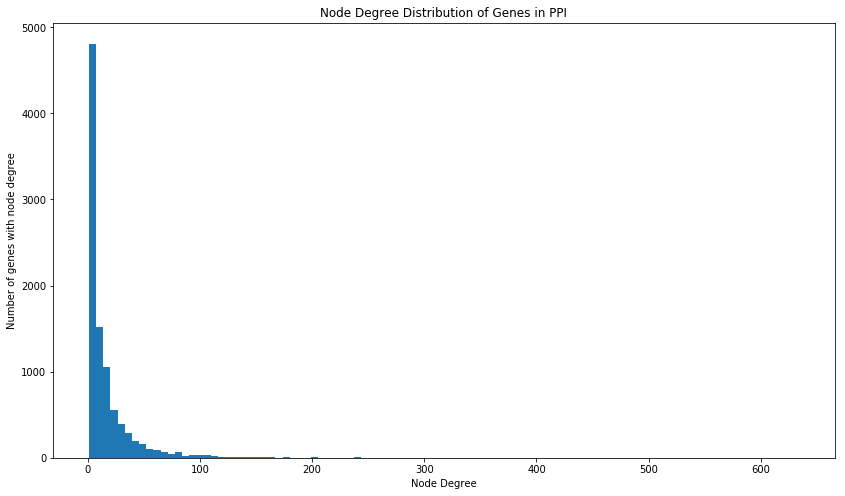

In [58]:
# plot node degree to check if distribution follows power law
node_degrees = ppi_network.sum()
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1,node_degrees.max(), 100)
ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

## STRING DB: Get PPI network
I also want to construct the adjacency matrix for the STRING DB PPI network because it seems as if ConsensusPathDB is lacking some interactions I am interested in.

In [63]:
# load data
interactions = pandas.read_csv('../data/networks/9606_stringdb_v10_5.txt.gz',
                                         header=0,
                                         sep=' ',
                                         encoding='utf8'
                                        )
# remove NAs and the trailing species name
interactions_nona = interactions.dropna()
interactions_nona.protein1 = interactions_nona.protein1.str.replace('9606.', '')
interactions_nona.protein2 = interactions_nona.protein2.str.replace('9606.', '')

# plot distribution of scores
fig = plt.figure(figsize=(14, 8))
ax = interactions_nona.combined_score.plot.hist(bins=50, title='Distribution of Scores')
plt.xlabel('Combined Scores (STRING DB)')

KeyboardInterrupt: 

In [55]:
# use bioMart to convert protein and gene IDs
mg = mygene.MyGeneInfo()
f = lambda x: x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
res = mg.getgenes(interactions_nona.protein1, 'symbol,ensembl.gene', scopes='ensembl.protein')
proteins1 = [f(x) for x in res]
res = mg.getgenes(interactions_nona.protein2, 'symbol,ensembl.gene', scopes='ensembl.protein')
proteins2 = [f(x) for x in res]

# put into dataframe
interactions_nona['gene1'] = proteins1
interactions_nona['gene2'] = proteins2

querying 1-20...done.
querying 1-20...done.


In [56]:
interactions_nona

,protein1,protein2,combined_score,gene1,gene2
0,ENSP00000000233,ENSP00000263431,260,ENSG00000004059,ENSG00000126583
1,ENSP00000000233,ENSP00000353863,164,ENSG00000004059,ENSG00000163848
2,ENSP00000000233,ENSP00000342026,159,ENSG00000004059,ENSG00000117592
3,ENSP00000000233,ENSP00000240874,194,ENSG00000004059,ENSG00000160145
4,ENSP00000000233,ENSP00000379847,164,ENSG00000004059,ENSG00000166478
5,ENSP00000000233,ENSP00000400088,189,ENSG00000004059,ENSG00000250506
6,ENSP00000000233,ENSP00000362465,240,ENSG00000004059,ENSG00000102383
7,ENSP00000000233,ENSP00000415070,164,ENSG00000004059,ENSG00000270011
8,ENSP00000000233,ENSP00000379387,164,ENSG00000004059,ENSG00000283034
9,ENSP00000000233,ENSP00000335632,224,ENSG00000004059,ENSG00000187446


In [62]:
INTERACTION_SCORE_THRESHOLD = 1

# extract adjacency matrix from interactions
N = len(gene_names)
adjacency_matrix = np.zeros((N, N), np.uint8)
adj_df = pandas.DataFrame(adjacency_matrix, index=gene_ids, columns=gene_ids)

count = 0
for index, row in interactions_nona.iterrows():
    if row.combined_score > INTERACTION_SCORE_THRESHOLD:
        i1 = row.gene1
        i2 = row.gene2
        if i1 in gene_ids and i2 in gene_ids:
            adj_df.ix[i1, i2] = 1
            adj_df.ix[i2, i1] = 1
        else:
            print ("not found {} -> {}".format(i1, i2))
            
    count += 1
    if count % 10000 == 0:
        print ("Processed {} out of {} rows".format(count, interactions_nona.shape[0]))

not found ENSG00000004059 -> ENSG00000126583
not found ENSG00000004059 -> ENSG00000283034


In [22]:
ppi_network.sum().max()

634.0

## Remove isolated genes from network & gene expression

In [82]:
# kick out all genes without interactions (isolated nodes)
genes_with_interactions = ppi_network.sum(axis=1) > 0
#ppi_network = ppi_network.ix[genes_with_interactions, genes_with_interactions]

# remove gene expression for isolated genes
ens_ids = ppi_network.index
gene_expression_short = ge_scaled.loc[gene_expression['Name'].isin(gene_names)]

# build list of gene names and ids
gene_names_ids = ppi_network.join(gene_expression['Name']).Name
gene_names_ids = pandas.DataFrame(gene_names_ids)
gene_names_ids = np.vstack([gene_names_ids.index, gene_names_ids.Name])
gene_names_ids = gene_names_ids.transpose(1, 0)

(10407, 2)

## Get Labels

## Generate Training, Testing & Validation Splits

## Write to hdf5 File on Disk

In [83]:
# create gene names
string_dt = h5py.special_dtype(vlen=str)

f = h5py.File('../data/preprocessing/ppi_networks.h5', 'w')
f.create_dataset('consensusPathDB_ppi', data=ppi_network, shape=ppi_network.shape)
f.create_dataset('gene_expression', data=gene_expression_short, shape=gene_expression_short.shape)
f.create_dataset('gene_names', data=gene_names_ids, dtype=string_dt)

# we don't have labels yet :-(
#f.create_dataset('y_train', data=y_train, shape=y_train.shape)
#f.create_dataset('y_test', data=y_test, shape=y_test.shape)
#f.create_dataset('y_val', data=y_val, shape=y_val.shape)

#f.create_dataset('mask_train', data=mask_train, shape=mask_train.shape)
#f.create_dataset('mask_test', data=mask_test, shape=mask_test.shape)
#f.create_dataset('mask_val', data=mask_val, shape=mask_val.shape)
f.close()

In [25]:
f.close()